In [1]:
import math

from portfolio import Portfolio
from backtest import Backtest
from strategies import *
from config import *
from utils import plot_distribution
from data_processing import *

In [2]:
# get data
spy_df = get_spy_data().loc[1130:]
# options_df = generate_option_chain(spy_df, generate_at='open')

In [3]:
# instantiation
my_portfolio = Portfolio(initial_portfolio_nominal_value, portolio_weights_config, collateral_ratio)
my_strategy = ZeroCostCollar0DTE(my_portfolio, 'SPY', spy_df)
env = Backtest(my_portfolio, spy_df)

# data cleaning and calculation
env.main_df = my_strategy.select_options(env.main_df, strike_selection_config)

# env.get_option_price_bs(options_df, spot_price='open')
env.get_option_price_polygon('SPY', 'open', bs_config)  # use bs model to calculate price if data not available on Polygon.io
env.update_option_price_at_close()
env.main_df = my_strategy.update_collar_pnl(env.main_df)

In [4]:
# Buy and hold SPY at market open on Day 0
first_date = env.main_df['Date'].values[0]
first_price = env.main_df['Open'].values[0]

target_spy_exposure = my_portfolio.initial_portfolio_nominal_value * my_portfolio.target_portfolio_weights['equity']
n_spy_to_buy = math.floor(target_spy_exposure / first_price)
my_strategy.execute_buy_and_hold_underlying('equity', first_date, first_price, n_spy_to_buy)

print('Portfolio position:', my_portfolio.positions)
print('Cash after buying SPY:', round(my_portfolio.cash, 2))
print('Transaction history')
my_portfolio.print_transaction_history()


Portfolio position: {'equity': {'SPY': 2413}}
Cash after buying SPY: 80091.98
Transaction history
2022-06-29: ['bought 2413 SPY at 381.23 on 2022-06-29.']


In [5]:
# Run the zero-cost collar strategy every day in spy_df
simulation_days = len(spy_df)
env.run(my_strategy, simulation_days)

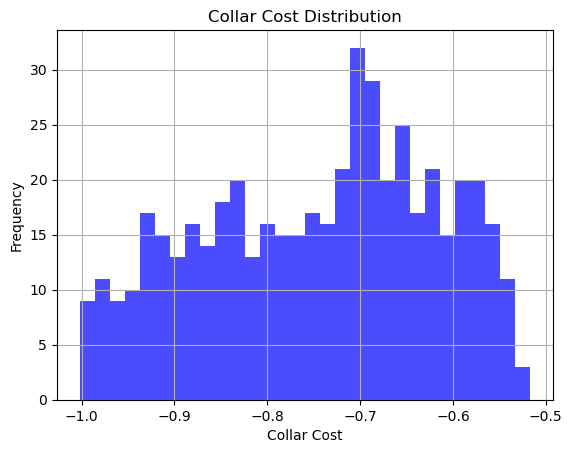

In [6]:
# Plot the distribution of collar strategy cost. Negative cost means the call premium is larger than put premium (i.e. receiving a credit to open)
plot_distribution(env.main_df['collar_cost'], x_label='Collar Cost', title='Collar Cost Distribution')

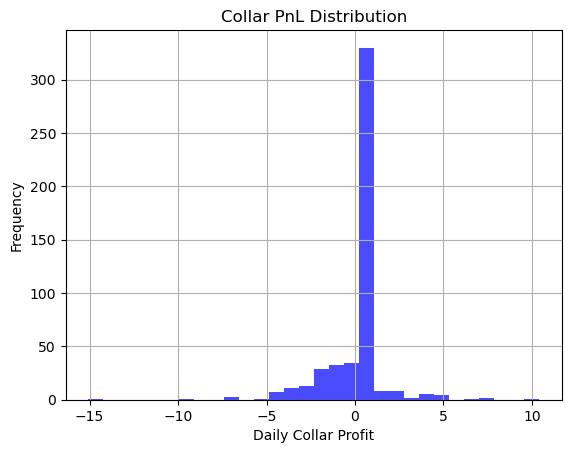

In [7]:
# Plot the distribution collar strategy PnL
plot_distribution(env.main_df['collar_pnl'], x_label='Daily Collar Profit', title='Collar PnL Distribution')

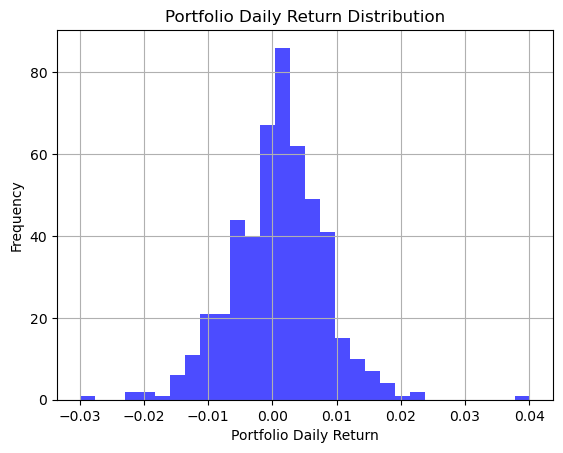

In [8]:
port_return = my_portfolio.calc_port_daily_return()
plot_distribution(port_return, x_label='Portfolio Daily Return', title='Portfolio Daily Return Distribution')

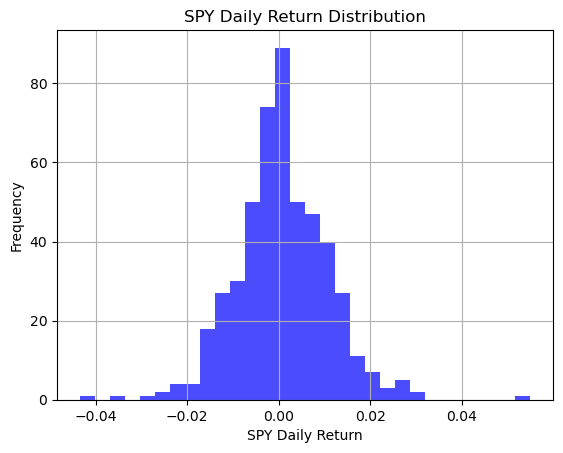

In [9]:
spy_return = env.calc_benchmark_return()
plot_distribution(spy_return, x_label='SPY Daily Return', title='SPY Daily Return Distribution')

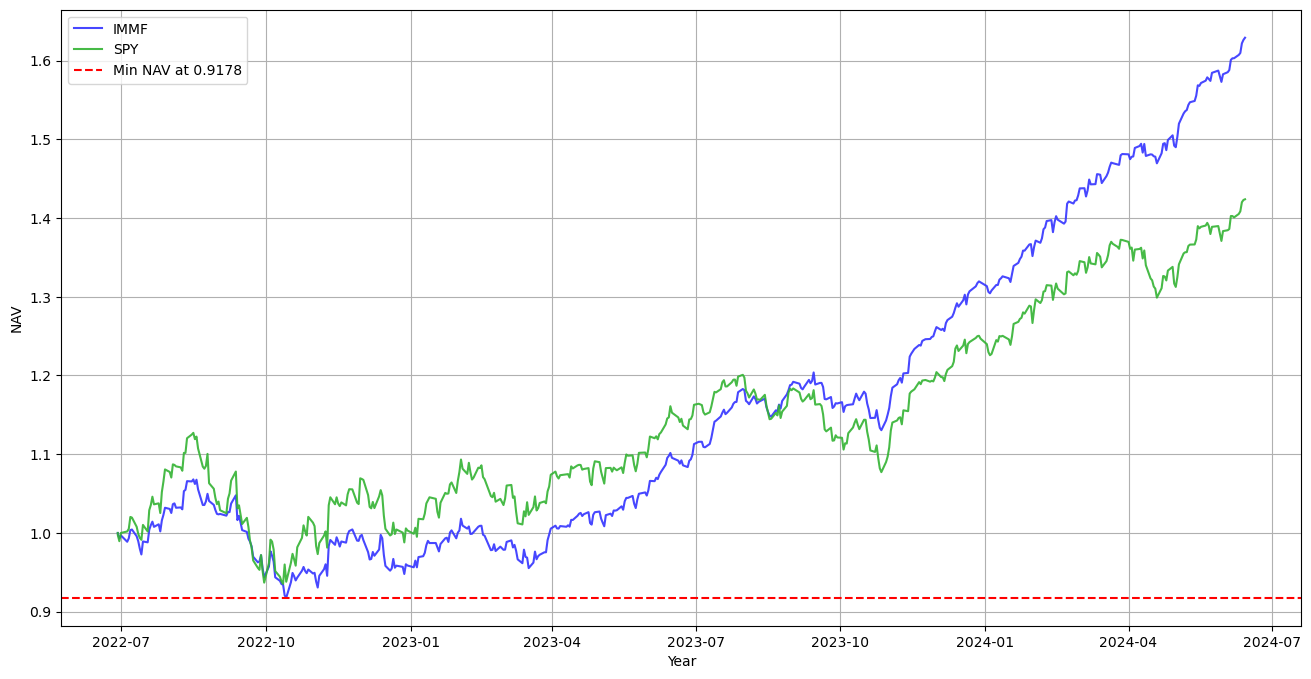

In [10]:
env.plot_nav_vs_spy()

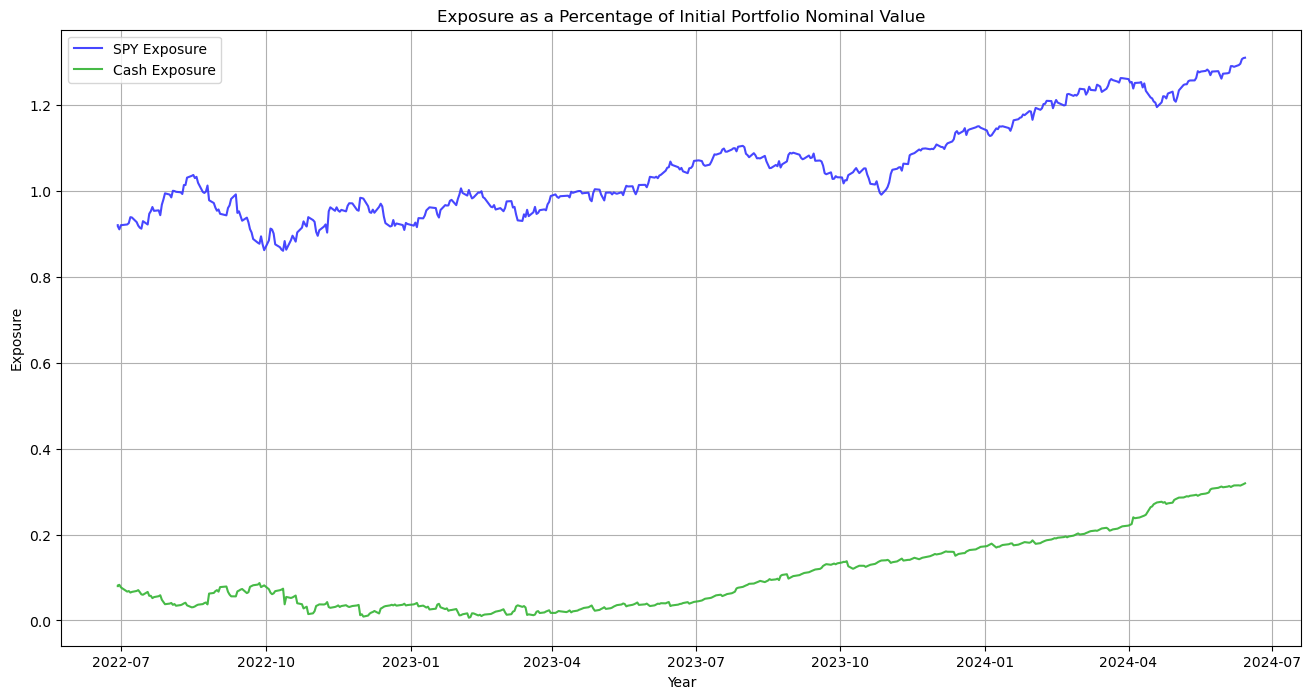

In [11]:
env.plot_exposure()

In [12]:
# my_portfolio.print_transaction_history()